# Imports

In [0]:
import torch

import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim

import torchvision
import matplotlib.pyplot as plt
from torchvision import datasets

import torchvision.transforms as transforms

import numpy as np
import pandas as pd
import torch.optim as optim
from torchvision import models

import tensorflow as tf

In [0]:
#num_classes=10
_imported=False
_loaded = False
_trained = False
epochs = 50

# transform = None
# train_loader = None
# validation_loader= None
# net  = None


# Data Loader

In [0]:

import os
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torchvision
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.transforms as transforms

#For converting the dataset to torchvision dataset format
class VowelConsonantDataset(Dataset):
    def __init__(self, file_path,train=True,transform=None):
        self.transform = transform
        self.file_path=file_path
        self.train=train
        self.file_names=[file for _,_,files in os.walk(self.file_path) for file in files]
        self.len = len(self.file_names)
        if self.train:
            self.classes_mapping=self.get_classes()
    def __len__(self):
        return len(self.file_names)
    
    def __getitem__(self, index):
        file_name=self.file_names[index]
        image_data=self.pil_loader(self.file_path+"/"+file_name)
        if self.transform:
            image_data = self.transform(image_data)
            #image_data = image_data.view(image_data.size(0), -1)
            
            #image_data = image_data.reshape(64*64*3,1)
        if self.train:
            file_name_splitted=file_name.split("_")
            Y1 = self.classes_mapping[file_name_splitted[0]]
            Y2 = self.classes_mapping[file_name_splitted[1]]
            z1,z2=torch.zeros(10),torch.zeros(10)
            z1[Y1-10],z2[Y2]=1,1
            #label=torch.stack([z1,z2])
            label_vowels=z1
            label_consonants=z2

            return image_data, label_vowels,label_consonants

        else:
            return image_data, file_name
          
    def pil_loader(self,path):
        with open(path, 'rb') as f:
            img = Image.open(f)
            return img.convert('RGB')

      
    def get_classes(self):
        classes=[]
        for name in self.file_names:
            name_splitted=name.split("_")
            classes.extend([name_splitted[0],name_splitted[1]])
        classes=list(set(classes))
        classes_mapping={}
        for i,cl in enumerate(sorted(classes)):
            classes_mapping[cl]=i
        return classes_mapping
    

# Load Data from Kaggle

In [0]:
#!pip install kaggle

In [0]:
def kaggleImport():
  
  # Import kaggle.json from google drive
  # This snippet will output a link which needs authentication from any google account
  from googleapiclient.discovery import build
  import io, os
  from googleapiclient.http import MediaIoBaseDownload
  from google.colab import auth
  auth.authenticate_user()
  drive_service = build('drive', 'v3')
  results = drive_service.files().list(
      q="name = 'kaggle.json'", fields="files(id)").execute()
  kaggle_api_key = results.get('files', [])
  print(kaggle_api_key)
  #filename = "/content/.kaggle/kaggle.json"
  filename = "/root/.kaggle/kaggle.json"
  os.makedirs(os.path.dirname(filename), exist_ok=True)
  request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
  fh = io.FileIO(filename, 'wb')
  downloader = MediaIoBaseDownload(fh, request)
  done = False
  while done is False:
      status, done = downloader.next_chunk()
      print("Download %d%%." % int(status.progress() * 100))
  os.chmod(filename, 600)
  _imported=True

In [0]:
def loadData():
  
  # Use this command in new cell
  #!kaggle datasets download -d stanfordu/street-view-house-numbers -w -f street-view-house-numbers.zip
  !kaggle competitions download -c padhai-hindi-vowel-consonant-classification
#   !kaggle competitions download -c padhai-tamil-vowel-consonant-classification


  # Unzip the data
  #!unzip street-view-house-numbers.zip
  !unzip train.zip

  !unzip test.zip
  _loaded=True

# Prepare Training & Test Data

In [0]:
# transform_train = transforms.Compose([
#     transforms.RandomResizedCrop(224), 
#     transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
#     ])

# transform_test = transforms.Compose([
#     transforms.RandomResizedCrop(224), 
#     transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
#     ])

In [0]:
# trainset = torchvision.datasets.CIFAR10(root='./data', train=True, 
#                                         download=True, 
#                                         transform=transform_train)
# testset = torchvision.datasets.CIFAR10(root='./data', train=False, 
#                                         download=True, 
#                                         transform=transform_test)

In [0]:
# trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

In [0]:
batch_size=30
train_on_gpu = torch.cuda.is_available()


In [0]:
def prepareTrainingData():
  
  global transform
  transform = transforms.Compose([
      transforms.ToTensor()])

  full_data = VowelConsonantDataset("train",train=True,transform=transform)
  #full_data = VowelConsonantDataset("../input/train/train",train=True,transform=transform)
  train_size = int(0.9 * len(full_data))
  validation_size = int(0.1 * len(full_data))
#   test_size = int(0.25 * len(full_data))
  #temp1_size= int(0.002 * len(full_data))
  #test_size = len(full_data) - train_size
  #temp1, temp2 =  random_split(full_data, [temp1_size, len(full_data)-temp1_size])
  #len(temp1)
  train_data, validation_data= random_split(full_data, [train_size, validation_size])
  #train_data, validation_data = random_split(temp1, [train_size, test_size])

  train_loader = torch.utils.data.DataLoader(train_data, batch_size, shuffle=True)
  validation_loader = torch.utils.data.DataLoader(validation_data, batch_size, shuffle=True)
#   test_loader = torch.utils.data.DataLoader(test_data, batch_size, shuffle=True)
  return transform, train_loader, validation_loader

In [0]:
def prepareTestData(transform):
  
  test_data = VowelConsonantDataset("test",train=False,transform=transform)
# ../input/train/test
  test_loader = torch.utils.data.DataLoader(test_data, batch_size,shuffle=False)
  return test_loader

In [0]:
# |dataiter = iter(train_loader)
# images, label_vowels, labels_consonants = dataiter.next()
# print(label_vowels.shape)
# for i, img in enumerate(images,0):
#   #img = images[i]
#   print(type(img))
#   npimg = img.numpy()
#   print(npimg.shape)
#   #print (label_vowels[i,0], labels[i,1])
#   print(label_vowels[i,0])
#   npimg = np.transpose(npimg, (1, 2, 0))
#   print(npimg.shape)
#   plt.figure(figsize = (1,1))
#   plt.imshow(npimg)
#   plt.show()
# #images = images.view(images.size(0), -1)
# print(images.shape)

# print(label_vowels[10,0])

In [0]:
# print (labels[:,0])
# type(labels[:,0])

In [0]:
def showImage(images):

  for i, img in enumerate(images,0):

    print(type(img))
    npimg = img.cpu().numpy()
    #print(npimg.shape)
    #print (labels[i,0], labels[i,1])

    npimg = np.transpose(npimg, (1, 2, 0))
    #print(npimg.shape)
    plt.figure(figsize = (1,1))
    plt.imshow(npimg)
    plt.show()  

In [0]:
# label_vowels = label_vowels.view(label_vowels.size(0),-1)

# for i in range(10,20):
#   img = images[i]
#   print(type(img))
#   npimg = img.numpy()
#   print(npimg.shape)
#   #print (labels[i,0], labels[i,1])
#   print(label_vowels[i])
#   npimg = np.transpose(npimg, (1, 2, 0))
#   print(npimg.shape)
#   plt.figure(figsize = (1,1))
#   plt.imshow(npimg)
#   plt.show() 

# Class Feed Forward Network

In [0]:
class FeedForwardNetwork(nn.Module):
  
  def __init__(self):
    super().__init__()
    torch.manual_seed(0)
    self.net = nn.Sequential(
        nn.Linear(12288,1024)  ,
        nn.LeakyReLU(), 
        nn.Linear(1024,64), 
        nn.LeakyReLU(),
        nn.Linear(64,4),
        nn.LeakyReLU(),
        nn.Linear(4,10),
        nn.Softmax()
    )

  def forward(self, X):
    return self.net(X)

In [0]:
def evaluation(dataloader, net, flag):
    total , correct, total_vowels, correct_vowels, total_consonants, correct_consonants = 0, 0, 0, 0, 0, 0
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#     print(device)
    for i,data in enumerate(dataloader,0):
        #inputs = inputs.view(inputs.size(0), -1)
        #label_vowels = labels[0,0]
        inputs, label_vowels, label_consonants = data

        label_vowels= label_vowels.view(label_vowels.size(0),-1)
        label_consonants= label_consonants.view(label_consonants.size(0),-1)
        inputs, label_vowels,label_consonants = inputs.to(device), label_vowels.to(device, dtype=torch.int64), label_consonants.to(device, dtype=torch.int64)
#         for i, lbl in enumerate(labels,0):
#           print(lbl)

#        showImage(inputs)   
        
        outputs = net(inputs)
#         for j,pred in enumerate(outputs.data,0):
#           print(pred)
        #_, pred = torch.max(outputs.data, 1)
        _, pred_vowels = torch.max(outputs[0], 1)
        _, pred_consonants = torch.max(outputs[1], 1)
      
#         result_arr.append(tf.strings.as_string(file_name), "V" * tf.strings.as_string(pred_vowels) )
#         vowel = tf.concat("V",tf.strings.as_string( pred_vowels.cpu()))    
#         consonants = tf.concat("C",tf.strings.as_string(pred_consonants.cpu()))
#         print ("vowel", vowel)
#         print ("consonants", consonants)

#        if flag == 0:
    
        total_vowels += label_vowels.size(0)
        correct_vowels += (pred_vowels == torch.max(label_vowels, 1)[1]).sum().item()
#        else:
        total_consonants += label_consonants.size(0)
        correct_consonants += (pred_consonants == torch.max(label_consonants, 1)[1]).sum().item()
    
        total +=label_vowels.size(0)
        pred_vowels == torch.max(label_vowels, 1)[1]
        pred_consonants == torch.max(label_consonants,1)[1]
        result_vowels = (pred_vowels == torch.max(label_vowels, 1)[1])
        result_consonants =(pred_consonants == torch.max(label_consonants,1)[1])

#         print("vowels", pred_vowels, torch.max(label_vowels, 1)[1], result_vowels)
#         print("consonants", pred_consonants, torch.max(label_consonants, 1)[1], result_consonants)
        
        correct += (result_vowels & result_consonants).sum().item()
        #correct += ((pred_vowels == torch.max(label_vowels, 1)[1]) and (pred_consonants == torch.max(label_consonants,1)[1])).sum().item()
#         print ("total & correct",i, "***",  total, correct)
        del inputs, label_vowels, label_consonants, outputs
        torch.cuda.empty_cache()

    return 100 * correct_vowels / total_vowels,100 * correct_consonants / total_consonants, 100 * correct / total

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [0]:
def predict(dataloader, net):
    result_arr = []
    file_arr=[]
    vowel_consonant=[]
    filename=[]
    
    for i,data in enumerate(dataloader,0):
        inputs, file_name = data
        

        inputs= inputs.to(device)
        outputs = net(inputs)
        _, pred_vowels = torch.max(outputs[0], 1)
        _, pred_consonants = torch.max(outputs[1], 1)
          
        vowel = np.char.add(np.full(pred_vowels.shape, "V").astype(str) , pred_vowels.cpu().numpy().astype(str))
        consonant=np.char.add(np.full(pred_consonants.shape, "_C").astype(str) , pred_consonants.cpu().numpy().astype(str))
#         np.insert(vowel_consonant,len(vowel_consonant), np.char.add(vowel,consonant))
#         np.insert(filename,len(filename), file_name)
        #np.concatenate((result,file_name), axis =1)
        vowel_consonant  = np.char.add(vowel,consonant)
        result_arr.append (vowel_consonant)
        file_arr.append(file_name)
    pred_list = []
    print("file_arr",file_arr)
#     print('result_arr', result_arr)
    
    for sublist in result_arr:
      for item in sublist:
          pred_list.append(item)
    for sublist in file_arr:
      for item in sublist:
          filename.append(item)
    result =np.array([np.asarray(filename),np.asarray( pred_list)])
    print (type(result))
#     print("filename",filename)
#     print('pred_list', pred_list)

    return result


# CNN 

In [0]:
class LeNet(nn.Module):
    def __init__(self): 
        super(LeNet, self).__init__()
        self.cnn_model = nn.Sequential(
            nn.Conv2d(3, 6, 5),         # (N, 3, 64, 64) -> (N,  6, 56, 56)
            nn.Tanh(),
            nn.AvgPool2d(2, stride=2),  # (N, 6, 56, 56) -> (N,  6, 28, 28)
            nn.Conv2d(6, 16, 5),        # (N, 6, 28, 28) -> (N, 16, 24, 24)  
            nn.Tanh(),
            nn.AvgPool2d(2, stride=2)   # (N,16, 24, 24) -> (N, 16, 12, 12)
        )
        self.fc_model = nn.Sequential(
            nn.Linear(2704,120),         # (N, 2704) -> (N, 120)
            nn.Tanh(),
            nn.Linear(120,84),          # (N, 120) -> (N, 84)
            nn.Tanh(),
            nn.Linear(84,10)            # (N, 84)  -> (N, 10)
        )
        self.fc_model1 = nn.Sequential(
            nn.Linear(2704,120),         # (N, 2704) -> (N, 120)
            nn.Tanh(),
            nn.Linear(120,84),          # (N, 120) -> (N, 84)
            nn.Tanh(),
            nn.Linear(84,10)            # (N, 84)  -> (N, 10)
        )
        
    def forward(self, x):
        x = self.cnn_model(x)
        x = x.view(x.size(0), -1)
        x1 = self.fc_model(x)
        x2= self.fc_model1(x)
        return torch.stack([x1,x2])      


In [0]:
class LeNet_ReLU(nn.Module):
    def __init__(self): 
        super(LeNet_ReLU, self).__init__()
        self.cnn_model = nn.Sequential(
            nn.Conv2d(3, 6, 5),         # (N, 3, 64, 64) -> (N,  6, 56, 56)
            nn.BatchNorm2d(6),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.AvgPool2d(2, stride=2),  # (N, 6, 56, 56) -> (N,  6, 28, 28)
            nn.Conv2d(6, 16, 5),        # (N, 6, 28, 28) -> (N, 16, 24, 24)  
            nn.BatchNorm2d(16),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.AvgPool2d(2, stride=2)   # (N,16, 24, 24) -> (N, 16, 12, 12)
        )
        self.fc_model = nn.Sequential(
            nn.Linear(2704,120),         # (N, 2704) -> (N, 120)
            nn.BatchNorm1d(120),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(120,84),          # (N, 120) -> (N, 84)
            nn.BatchNorm1d(84),
            nn.Dropout(0.5),
            
            nn.ReLU(),
            nn.Linear(84,10)            # (N, 84)  -> (N, 10)
        )
        self.fc_model1 = nn.Sequential(
            nn.Linear(2704,120),         # (N, 2704) -> (N, 120)
            nn.BatchNorm1d(120),
            nn.Dropout(0.5),
            
            nn.ReLU(),
            nn.Linear(120,84),          # (N, 120) -> (N, 84)
            nn.BatchNorm1d(84),
            nn.Dropout(0.5),
            
            nn.ReLU(),
            nn.Linear(84,10)            # (N, 84)  -> (N, 10)
        )
        
    def forward(self, x):
        x = self.cnn_model(x)
        x = x.view(x.size(0), -1)
        x2= self.fc_model1(x)
        x = self.fc_model(x)
        return torch.stack([x,x2])
      

In [0]:
class LeNet_LeakyReLU(nn.Module):
    def __init__(self): 
        super(LeNet_LeakyReLU, self).__init__()
        self.cnn_model = nn.Sequential(
            nn.Conv2d(3, 6, 5),         # (N, 3, 64, 64) -> (N,  6, 56, 56)
            nn.BatchNorm2d(6),
            nn.Dropout(0.5),
            nn.LeakyReLU(),
            nn.AvgPool2d(2, stride=2),  # (N, 6, 56, 56) -> (N,  6, 28, 28)
            nn.Conv2d(6, 16, 5),        # (N, 6, 28, 28) -> (N, 16, 24, 24)  
            nn.BatchNorm2d(16),
            nn.Dropout(0.5),
            nn.LeakyReLU(),
            nn.AvgPool2d(2, stride=2)   # (N,16, 24, 24) -> (N, 16, 12, 12)
        )
        self.fc_model = nn.Sequential(
            nn.Linear(2704,1200),         # (N, 2704) -> (N, 1200)
            nn.BatchNorm1d(1200),
            nn.Dropout(0.5),
            nn.LeakyReLU(),
            nn.Linear(1200,600),          # (N, 1200) -> (N, 600)
            nn.BatchNorm1d(600),
            nn.Dropout(0.5),
            nn.LeakyReLU(),
            nn.Linear(600,200),          # (N, 600) -> (N, 200)
            nn.BatchNorm1d(200),
            nn.Dropout(0.5),
            nn.LeakyReLU(),
            nn.Linear(200,10)            # (N, 200)  -> (N, 10)
        )
        self.fc_model1 = nn.Sequential(
            nn.Linear(2704,1000),         # (N, 2704) -> (N, 1000)
            nn.BatchNorm1d(1000),
            nn.Dropout(0.5),
            nn.LeakyReLU(),
            nn.Linear(1000,500),         # (N, 1000) -> (N, 500)
            nn.BatchNorm1d(500),
            nn.Dropout(0.5),
            nn.LeakyReLU(),
            nn.Linear(500,100),         # (N, 500) -> (N, 100)
            nn.BatchNorm1d(100),
            nn.Dropout(0.5),
            nn.LeakyReLU(),
            nn.Linear(100,84),          # (N, 100) -> (N, 84)
            nn.BatchNorm1d(84),
            nn.Dropout(0.5),
            nn.LeakyReLU(),
            nn.Linear(84,10)            # (N, 84)  -> (N, 10)
        )
#         self.fc_model = nn.Sequential(
#             nn.Linear(2704,1024),         # (N, 2704) -> (N, 1200)
#             nn.BatchNorm1d(1024),
#             nn.Dropout(0.2),
#             nn.LeakyReLU(),
#             nn.Linear(1024,10)          # (N, 1200) -> (N, 600)
#         )
#         self.fc_model1 = nn.Sequential(
#             nn.Linear(2704,1024),         # (N, 2704) -> (N, 1000)
#             nn.BatchNorm1d(1024),
#             nn.Dropout(0.2),
#             nn.LeakyReLU(),
#             nn.Linear(1024,512),         # (N, 1000) -> (N, 500)
#             nn.BatchNorm1d(512),
#             nn.Dropout(0.2),
#             nn.LeakyReLU(),
#             nn.Linear(512,10)         # (N, 500) -> (N, 100)
#         )
        
    def forward(self, x):
        x = self.cnn_model(x)
        x = x.view(x.size(0), -1)
        x2= self.fc_model1(x)
        x = self.fc_model(x)
        return torch.stack([x,x2])

In [0]:
def LoadModel(model,activation_fn, optimation_fn):
  net=None
  if (model == "FF"):
    net=FeedForwardNetwork().to(device)
  elif (model == "CNN"):
    if (activation_fn == "Tanh"):
      net=LeNet().to(device)
    elif (activation_fn == "ReLU"):
      net=LeNet_ReLU().to(device)
    elif (activation_fn == "LeakyReLU"):
      net=LeNet_LeakyReLU().to(device)
  elif (model == "VGG"):
    net = vggNet().to(device)
  elif (model == "ALEXNET"):
    net = alexNet().to(device)
#     final_in_features = net.classifier[6].in_features
#     mod_classifier = list(net.classifier.children())[:-1]
#     mod_classifier.extend([nn.Linear(final_in_features, num_classes)])
#     net.classifier = nn.Sequential(*mod_classifier)

#     print(mod_classifier)
  #loss_fn = nn.CrossEntropyLoss()
  
  #opt = optim.Adam(net.parameters())
  #opt = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)

  #opt=optim.RMSprop(net.parameters())
  #opt = optim.Adagrad(net.parameters(),lr=0.5)
  return net

In [0]:
class Params(object):
    def __init__(self, activation_fn,optim, model, epochs):
        self.activation_fn = activation_fn
        self.optim = optim
        self.model = model
        self.epochs = epochs
        




# Large CNN Models

In [0]:
def PredictVowelsAndConsonants(args, net, train_loader, validation_loader):
  print(args.model, args.activation_fn, args.optim)
  
  %%time  
  loss1_arr = []
  loss_epoch_arr1 = []
  loss2_arr = []
  loss_epoch_arr2 = []
  max_epochs = args.epochs
  opt = optim.Adam(net.parameters(),lr=0.0001) #, weight_decay=1e-5 , lr=0.01 #, lr=1e-5, weight_decay=1e-5 (0.001)
#   torch.optim.Adam(params, lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)?
  #opt = optim.SGD(net.parameters(), lr=0.1, momentum=0.6)
  loss_fn = nn.CrossEntropyLoss()
#   loss_fn = nn.MultiLabelSoftMarginLoss()
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#   print(device)
  net = net.to(device)
  for epoch in range(max_epochs):

      for i, data in enumerate(train_loader, 0):
          inputs, label_vowels, label_consonants = data
          #showImage(inputs[i])
          #inputs = inputs.view(inputs.size(0), -1)
          #label_vowels = labels[0]
          label_vowels = label_vowels.view(label_vowels.size(0),-1)
          label_consonants = label_consonants.view(label_consonants.size(0),-1)
          inputs, label_vowels, label_consonants = inputs.to(device), label_vowels.to(device, dtype=torch.int64),label_consonants.to(device, dtype=torch.int64)

          opt.zero_grad()

          outputs = net(inputs)
#           print("type", type(outputs))
          #print(outputs[0])
          #_, pred= torch.max(outputs.data, 1)
          _, pred_vowels= torch.max(outputs[0], 1)
          _, pred_consonants= torch.max(outputs[1], 1)
          #print("max", pred,  torch.max(labels, 1)[1])
          #loss = loss_fn(outputs, torch.max(label_vowels, 1)[1]) #+ loss_fn(outputs, torch.max(label_consonants, 1)[1])
          
#           print ("output shape", outputs[0].shape)
#           print("inputs shape", inputs.shape)
#           print("labes shape", label_vowels.shape, label_consonants.shape)
#           print ("label",  outputs[0], torch.max(label_vowels, 1)[1])
          loss1 = loss_fn(outputs[0], torch.max(label_vowels, 1)[1]) 
          loss2 = loss_fn(outputs[1], torch.max(label_consonants, 1)[1])
          loss = loss1 + loss2
          #print(loss1, loss2, loss)
          loss.backward()
          opt.step()
          loss1_arr.append(loss1.item())       
          loss2_arr.append(loss2.item())       
      loss_epoch_arr1.append(loss1.item())
      loss_epoch_arr2.append(loss2.item())

      training_accuracy_score = evaluation(train_loader,net,0)
      validation_accuracy_score = evaluation(validation_loader,net,0)
      del inputs, label_vowels, label_consonants, outputs
      torch.cuda.empty_cache()
      
      print('Epoch: %d/%d, Overall Train acc: %0.2f,Overall Validation acc: %0.2f' % (epoch, max_epochs,training_accuracy_score[2],validation_accuracy_score[2]))
  plt.figure()
  plt.subplot(211)
  plt.plot(loss_epoch_arr1)

  plt.subplot(212)
  
  plt.plot(loss_epoch_arr2)
  plt.show()

In [0]:
from torchvision import models
vgg = models.vgg16_bn(pretrained=True) #(pretrained=True)
print(vgg)

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/checkpoints/vgg16_bn-6c64b313.pth
100%|██████████| 553507836/553507836 [00:23<00:00, 23694572.90it/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3)

In [0]:
for param in vgg.parameters():
    param.requires_grad = False

In [0]:
new_classifier = nn.Sequential(*list(vgg.classifier.children())[:-7])
vgg.classifier = new_classifier
print(vgg)
vgg= vgg.to(device)
# final_in_features = vgg.classifier[6].in_features
# vgg.classifier[6] = nn.Linear(final_in_features, num_classes)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3)

In [0]:
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3)

In [0]:
class LinearNet(nn.Module):
    def __init__(self): 
        super(LinearNet, self).__init__()
        self.fc_model = nn.Sequential(
            nn.Linear(25088,12288),         # (N, 2704) -> (N, 1200)
            nn.BatchNorm1d(12288),
            nn.Dropout(0.5),
            nn.LeakyReLU(),
            nn.Linear(12288,4096),         # (N, 2704) -> (N, 1200)
            nn.BatchNorm1d(4096),
            nn.Dropout(0.5),
            nn.LeakyReLU(),
            nn.Linear(4096,1024)         # (N, 2704) -> (N, 1200)
            
        )
        self.fc_model1 = nn.Sequential(
              nn.Linear(1024,10)
#             nn.Linear(1024,512),         # (N, 1000) -> (N, 500)
#             nn.BatchNorm1d(512),
#             nn.Dropout(0.5),
#             nn.LeakyReLU(),
#             nn.Linear(512,256),         # (N, 500) -> (N, 100)        
#             nn.LeakyReLU(),
#             nn.Linear(256,128),
#             nn.LeakyReLU(),
#             nn.Linear(128,10)
        )
        self.fc_model2 = nn.Sequential(
              nn.Linear(1024,512),
              nn.BatchNorm1d(512),
              nn.Dropout(0.2),
              nn.LeakyReLU(),
              nn.Linear(512,256),
              nn.BatchNorm1d(256),
              nn.Dropout(0.2),
              nn.LeakyReLU(),
              nn.Linear(256,128),
              nn.BatchNorm1d(128),
              nn.Dropout(0.2),
              nn.LeakyReLU(),
              nn.Linear(128,10)
# #             nn.Linear(1024,1024),          # (N, 1200) -> (N, 600)
#             nn.BatchNorm1d(1024),
#             nn.Dropout(0.5),
#             nn.LeakyReLU(),
#             nn.Linear(1024,512),
#             nn.LeakyReLU(),
#             nn.Linear(512,128),
#             nn.LeakyReLU(),
#             nn.Linear(128,10)

        )
        

In [1]:
class vggNet(LinearNet):
    def __init__(self): 
        super(vggNet, self).__init__()
    def forward(self, x):
        x1 = vgg(x)
#         x1.requires_grad
        x1 = x1.view(x1.size(0), -1)
        x1 = self.fc_model(x1)
        
        x1 = self.fc_model2(x1)
        x2 = vgg(x2)
        x2 = x2.view(x2.size(0), -1)
        x2= self.fc_model(x2)
        x2= self.fc_model1(x2)
        return torch.stack([x1,x2])


NameError: ignored

In [0]:
alexnet = models.alexnet(pretrained=True)
print(alexnet)
for param in alexnet.parameters():
    param.requires_grad = False
new_classifier = nn.Sequential(*list(alexnet.classifier.children())[:-7])
alexnet.classifier = new_classifier
print(alexnet)
alexnet= alexnet.to(device)
print(alexnet)    

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/checkpoints/alexnet-owt-4df8aa71.pth
100%|██████████| 244418560/244418560 [00:09<00:00, 24637291.22it/s]


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p

In [0]:
class LinearAlexNet(nn.Module):
    def __init__(self): 
        super(LinearAlexNet, self).__init__()
        self.fc_model = nn.Sequential(
            nn.Linear(9216,4096),         # (N, 2704) -> (N, 1200)
            nn.BatchNorm1d(4096),
            nn.Dropout(0.5),
            nn.LeakyReLU(),
            nn.Linear(4096,1024),         # (N, 2704) -> (N, 1200)
            nn.BatchNorm1d(1024),
            nn.Dropout(0.5),
            nn.LeakyReLU()
        )
        self.fc_model1 = nn.Sequential(
            nn.Linear(1024,512),         # (N, 1000) -> (N, 500)
            nn.BatchNorm1d(512),
            nn.Dropout(0.5),
            nn.LeakyReLU(),
            nn.Linear(512,10)         # (N, 500) -> (N, 100)        
        )
        self.fc_model2 = nn.Sequential(
            nn.Linear(1024,10)          # (N, 1200) -> (N, 600)
        )        

In [0]:
class alexNet(LinearAlexNet):
    def __init__(self): 
        super(alexNet, self).__init__()
    def forward(self, x):
        x = alexnet(x)
        x = x.view(x.size(0), -1)
        x = self.fc_model(x)
        x2= self.fc_model1(x)
        x = self.fc_model2(x)
        return torch.stack([x,x2])     


In [0]:
def trainModel(_imported, _loaded):
  global net
  if (not _imported):
    kaggleImport()
  if (not _loaded):
    loadData()
  transform, train_loader, validation_loader = prepareTrainingData()
  
  args= Params("LeakyReLU", "Adam", "VGG", epochs)
  net = LoadModel(args.model, args.activation_fn, args.optim)
  PredictVowelsAndConsonants(args,net, train_loader, validation_loader)


In [0]:
def predictOutput():
  test_loader = prepareTestData(transform)
  
  print(test_loader, transform)
  result_arr = predict(test_loader,net)
  
  print(result_arr[0])
  submission = pd.DataFrame({'ImageId':result_arr[0], 'Class':[0]*result_arr[0].size})
  submission = submission[['ImageId', 'Class']]
  submission['Class'] = result_arr[1]
  submission.to_csv("submission.csv", index=False)
  # submission.groupby('Class').size()

#Train Model

W0725 11:53:15.880493 140208829634432 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0 or google-auth
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import Lock

[{'id': '1ozWFEARIRnku3i0XJEhlH9T0YSj88mFR'}]
Download 100%.
sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)
test.zip: Skipping, found more recently modified local copy (use --force to force download)
train.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  train.zip
replace train/V0_C0_25.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: train/V0_C0_25.png      
  inflating: train/V0_C2_18.png      
  inflating: train/V0_C2_36.png      
  inflating: train/V0_C4_22.png      
  inflating: train/V0_C6_34.png      
  inflating: train/V0_C6_41.png      
  inflating: train/V0_C6_43.png      
  inflating: train/V2_C5_87.png      
  inflating: train/V2_C5_92.png      
  inflating: train/V2_C5_97.png      
  inflating: train/V2_C7_63.png      
  inflating: train/V2_C7_75.png      
  inflating: train/V2_C9_33.png      
  inflating: train/V2_C9_38.png      
  inflating: train/V2_C9_42.p

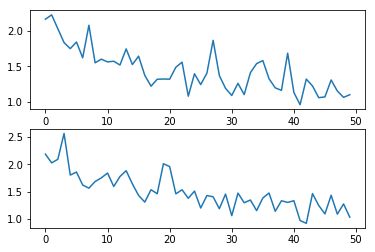

In [0]:
trainModel(False, False)
# print(_imported)

In [0]:
predictOutput()